In [1]:
import bs4
from bs4 import BeautifulSoup
import requests
import re
import json
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_palette('muted')
sns.set_style('whitegrid')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,\
AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, \
RandomForestClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor

ImportError: No module named model_selection

## Webscraping

### IMDB: Get film ids

In [181]:
# Function that will make an api call to omdbapi.com and return film id

def get_id_250():
    response = requests.get('http://www.imdb.com/chart/top')
    html = response.text
    entries = re.findall("<a href.*?/title/(.*?)/", html)
    return list(set(entries))

entries = get_id_250()

In [182]:
print len(entries)
print entries[:2]

250
[u'tt2582802', u'tt0047478']


### Fill in film data from omdapi.com

In [183]:
# Function that will make an api call to omdbapi.com and return film data by film id
"""  
     Decided to include full plot summary in case I choose to use NLTK for predicting in future
     Decided to include Rotten Tomatoes ratings and metrics as it may also be a useful feature in models 
"""

# From JSON/APIs lab
def get_entry(entry):
    res = requests.get('http://www.omdbapi.com/?i='+entry+'&plot=full&r=json&tomatoes=true')
    if res.status_code != 200:
        print entry, res.status_code
    else:
        print '.',
    try:
        j = json.loads(res.text)
    except ValueError:
        j = None
    return j

entries_dict_list = [get_entry(e) for e in entries]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [184]:
len(entries_dict_list)

250

In [185]:
df = pd.DataFrame(entries_dict_list)
df.head(1)

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,tomatoFresh,tomatoImage,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoURL,tomatoUserMeter,tomatoUserRating,tomatoUserReviews
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,N/A,USA,24 Feb 2015,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,...,246,certified,94,8.6,261,15,http://www.rottentomatoes.com/m/whiplash_2014/,94,4.5,66092


In [14]:
print df.shape

(250, 35)


### IMDB: Get gross, opening weekend and budget

In [186]:
def get_gross(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        gross_list = re.findall("Gross:</h4>[ ]*\$([^ ]*)", html)
        gross = int(gross_list[0].replace(',', ''))
        print '.',
        return gross
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [187]:
grosses = [(e, get_gross(e)) for e in entries]

. . . . . . .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . .
list index out of range tt0057115 200
.
list index out of range tt0071315 200
. . . .
list index out of range tt0074896 200
. .
list index out of range tt0021749 200
. .
list index out of range tt0053125 200
. . .
list index out of range tt1220719 200

list index out of range tt0025316 200
. .
list index out of range tt0083922 200
. . .
list index out of range tt0072684 200
.
list index out of range tt0074958 200
. . . .
list index out of range tt0036775 200
. . . . . .
list index out of range tt0978762 200
. .
list index out of range tt0080678 200
. .
list index out of range tt0056592 200
.
list index out of range tt0095327 200
. . . . . . . . .
list index out of range tt0046438 200
.
list index out of range tt0015864 200
.
list index out of range tt0045152 200
. . . .
list index out of range tt0046911 200
.
list index out of range tt0050986 200
.
list index out of range tt0091251 200


In [188]:
df1 = pd.DataFrame(grosses, columns=['imdbID', 'Gross'])
df1.head(3)

,imdbID,Gross
0,tt2582802,13092000.0
1,tt0047478,269061.0
2,tt0082971,242374454.0


In [189]:
def get_opening(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        opening_list = re.findall("Opening Weekend:</h4>[ ]*\$([^ ]*)", html)
        opening = int(opening_list[0].replace(',', ''))
        print '.',
        return opening
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [190]:
opening = [(e, get_opening(e)) for e in entries]

. . .
list index out of range tt0050212 200
. . .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . .
list index out of range tt0057115 200
.
list index out of range tt0071315 200

list index out of range tt0114746 200
. . .
list index out of range tt0074896 200
. .
list index out of range tt0021749 200
.
list index out of range tt1187043 200

list index out of range tt0053125 200
.
list index out of range tt0112471 200
.
list index out of range tt1220719 200

list index out of range tt0025316 200
. .
list index out of range tt0083922 200

list index out of range tt0088247 200
.
list index out of range tt0087843 200

list index out of range tt0072684 200
.
list index out of range tt0074958 200
.
list index out of range tt0052618 200
. .
list index out of range tt0036775 200
.
list index out of range tt0110357 200
. . .
list index out of range tt0075148 200

list index out of range tt0978762 200
.
list index out of range tt0036868 200

list index out o

In [191]:
df2 = pd.DataFrame(opening, columns=['imdbID', 'Opening'])
df2.head(3)

,imdbID,Opening
0,tt2582802,135388.0
1,tt0047478,21830.0
2,tt0082971,1673731.0


In [192]:
def get_budget(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        budget_list = re.findall("Budget:</h4>[ ]*\$([^ ]*)", html)
        budget = int(budget_list[0].replace(',', ''))
        print '.',
        return budget
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [193]:
budgets = [(e, get_budget(e)) for e in entries]

. . . . . . .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . . . . . .
list index out of range tt0363163 200
.
list index out of range tt1865505 200
. . . . .
list index out of range tt1187043 200
. . . . . . . . . . . . . . . . . . . . . . .
list index out of range tt0071853 200
. .
list index out of range tt0978762 200
. . . . . . . . . . . .
list index out of range tt0044741 200
. . . .
list index out of range tt0046438 200
. . . . . . . .
list index out of range tt0046911 200
.
list index out of range tt0050986 200
.
list index out of range tt0091251 200
. . . . . .
list index out of range tt0113247 200
. . . . . . . . . . .
list index out of range tt0060827 200
. .
list index out of range tt0211915 200
. . . . . . .
list index out of range tt0053198 200
. . . . . . . . . .
list index out of range tt0041546 200
. . . . . .
list index out of range tt0092067 200
. .
list index out of range tt0120735 200
.
list index out of range tt1954470 200
. .

In [194]:
df3 = pd.DataFrame(budgets, columns=['imdbID', 'Budget'])
df3.head()

,imdbID,Budget
0,tt2582802,3300000.0
1,tt0047478,2000000.0
2,tt0082971,18000000.0
3,tt0050212,3000000.0
4,tt0848228,220000000.0


In [198]:
print df1.columns
print df2.columns
print df3.columns

Index([u'imdbID', u'Gross'], dtype='object')
Index([u'imdbID', u'Opening'], dtype='object')
Index([u'imdbID', u'Budget'], dtype='object')


In [195]:
df_gross = df1.copy()
df_opening = df2.copy()
df_budget = df3.copy()

In [196]:
print df_gross.columns, df_gross.shape
print df_opening.columns, df_opening.shape
print df_budget.columns, df_opening.shape

Index([u'imdbID', u'Gross'], dtype='object') (250, 2)
Index([u'imdbID', u'Opening'], dtype='object') (250, 2)
Index([u'imdbID', u'Budget'], dtype='object') (250, 2)


### Merge all dataframes into 1 master df

In [197]:
# Merge gross, opening and budget dfs
df_imdb = pd.merge(df_gross, df_opening, on="imdbID")
df_imdb = pd.merge(df_imdb, df_budget, on="imdbID")
df_imdb.head(3)

,imdbID,Gross,Opening,Budget
0,tt2582802,13092000.0,135388.0,3300000.0
1,tt0047478,269061.0,21830.0,2000000.0
2,tt0082971,242374454.0,1673731.0,18000000.0


In [199]:
# Merge original df (from omdbapi) with df_imdb
df = pd.merge(df, df_imdb)
print df.shape
df.head(3)

(250, 38)


,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,tomatoRating,tomatoReviews,tomatoRotten,tomatoURL,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,Gross,Opening,Budget
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,N/A,USA,24 Feb 2015,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,...,8.6,261,15,http://www.rottentomatoes.com/m/whiplash_2014/,94,4.5,66092,13092000.0,135388.0,3300000.0
1,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Nominated for 2 Oscars. Another 5 wins & 6 nom...,N/A,Japan,01 Mar 1999,Akira Kurosawa,"Action, Adventure, Drama",Japanese,98,"A veteran samurai, who has fallen on hard time...",...,9.3,57,0,http://www.rottentomatoes.com/m/1018639-seven_...,97,4.5,89264,269061.0,21830.0,2000000.0
2,"Harrison Ford, Karen Allen, Paul Freeman, Rona...",Won 4 Oscars. Another 30 wins & 23 nominations.,N/A,USA,21 Oct 2003,Steven Spielberg,"Action, Adventure","English, German, Hebrew, Spanish, Arabic, Nepali",85,The year is 1936. An archeology professor name...,...,9.2,71,4,http://www.rottentomatoes.com/m/raiders_of_the...,96,4.1,823404,242374454.0,1673731.0,18000000.0


In [200]:
#################
#################

# Copy of merged raw dfs without dropping/rearranging columns or cleaning
# dfc1 = df.copy()

#################
#################

In [ ]:
# df.to_csv('film_df_v5.csv', sep=',', encoding='utf-8')

### Reorder and drop columns

In [201]:
df.columns = [i.encode("utf-8") for i in df.columns]
df.columns.values

array(['Actors', 'Awards', 'BoxOffice', 'Country', 'DVD', 'Director',
       'Genre', 'Language', 'Metascore', 'Plot', 'Poster', 'Production',
       'Rated', 'Released', 'Response', 'Runtime', 'Title', 'Type',
       'Website', 'Writer', 'Year', 'imdbID', 'imdbRating', 'imdbVotes',
       'tomatoConsensus', 'tomatoFresh', 'tomatoImage', 'tomatoMeter',
       'tomatoRating', 'tomatoReviews', 'tomatoRotten', 'tomatoURL',
       'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 'Gross',
       'Opening', 'Budget'], dtype=object)

In [202]:
original_cols = df.columns.values
cols_list = [
    'imdbID', 'Title', 
    'BoxOffice', 'Gross', 'Opening', 'Budget', 
    'Year', 'Released', 
    'Metascore', 'imdbRating', 'imdbVotes',
    'tomatoMeter', 'tomatoRating', 'tomatoReviews', 
    'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 
    'tomatoFresh', 'tomatoRotten',
    'Awards', 'Actors', 'Director', 'Writer', 'Production',  
    'Country', 'Language', 'Genre', 'Rated', 'Runtime', 'Plot', 
    'tomatoConsensus', 'tomatoImage',  'tomatoURL',
    'Website',  'DVD',  'Poster', 'Type', 'Response']

# columns to delete:
# ['tomatoConsensus', 'tomatoImage',  'tomatoURL', 'Response',
# 'Type', 'Poster', 'Website', 'DVD']

print len(original_cols)
print len(cols_list)

38
38


In [203]:
print df['Type'].value_counts()
print df['Response'].value_counts()

movie    250
Name: Type, dtype: int64
True    250
Name: Response, dtype: int64


In [204]:
# Reindex column order
df = df.reindex(columns=cols_list)
print df.shape
print df.columns.values
df.head(1)

(250, 38)
['imdbID' 'Title' 'BoxOffice' 'Gross' 'Opening' 'Budget' 'Year' 'Released'
 'Metascore' 'imdbRating' 'imdbVotes' 'tomatoMeter' 'tomatoRating'
 'tomatoReviews' 'tomatoUserMeter' 'tomatoUserRating' 'tomatoUserReviews'
 'tomatoFresh' 'tomatoRotten' 'Awards' 'Actors' 'Director' 'Writer'
 'Production' 'Country' 'Language' 'Genre' 'Rated' 'Runtime' 'Plot'
 'tomatoConsensus' 'tomatoImage' 'tomatoURL' 'Website' 'DVD' 'Poster'
 'Type' 'Response']


,imdbID,Title,BoxOffice,Gross,Opening,Budget,Year,Released,Metascore,imdbRating,...,Runtime,Plot,tomatoConsensus,tomatoImage,tomatoURL,Website,DVD,Poster,Type,Response
0,tt2582802,Whiplash,N/A,13092000.0,135388.0,3300000.0,2014,15 Oct 2014,88,8.5,...,107 min,A promising young drummer enrolls at a cut-thr...,"Intense, inspiring, and well-acted, Whiplash i...",certified,http://www.rottentomatoes.com/m/whiplash_2014/,http://sonyclassics.com/whiplash/,24 Feb 2015,https://images-na.ssl-images-amazon.com/images...,movie,True


In [205]:
cols_to_delete = ['tomatoConsensus', 'tomatoImage',  'tomatoURL', 'Response',
                  'Type', 'Poster', 'Website', 'DVD']

In [206]:
# Create final master df with only 30 columns
df = df[['imdbID', 'Title', 
    'BoxOffice', 'Gross', 'Opening', 'Budget', 
    'Year', 'Released', 
    'Metascore', 'imdbRating', 'imdbVotes',
    'tomatoMeter', 'tomatoRating', 'tomatoReviews', 
    'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 
    'tomatoFresh', 'tomatoRotten',
    'Awards', 'Actors', 'Director', 'Writer', 'Production',  
    'Country', 'Language', 'Genre', 'Rated', 'Runtime', 'Plot']]

print df.shape
df.head(2)

(250, 30)


,imdbID,Title,BoxOffice,Gross,Opening,Budget,Year,Released,Metascore,imdbRating,...,Actors,Director,Writer,Production,Country,Language,Genre,Rated,Runtime,Plot
0,tt2582802,Whiplash,N/A,13092000.0,135388.0,3300000.0,2014,15 Oct 2014,88,8.5,...,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Damien Chazelle,Damien Chazelle,Sony Pictures Classics,USA,English,"Drama, Music",R,107 min,A promising young drummer enrolls at a cut-thr...
1,tt0047478,Seven Samurai,N/A,269061.0,21830.0,2000000.0,1954,19 Nov 1956,98,8.7,...,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Akira Kurosawa,"Akira Kurosawa (screenplay), Shinobu Hashimoto...",Columbia Pictures,Japan,Japanese,"Action, Adventure, Drama",UNRATED,207 min,"A veteran samurai, who has fallen on hard time..."


In [208]:
#######################
#######################

# Copy of merged df with columns cleaned
#dfc2 = df.copy()

#######################
#######################

## Data Cleaning / Munging

### Converting dtypes

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 30 columns):
imdbID               250 non-null object
Title                250 non-null object
BoxOffice            250 non-null object
Gross                184 non-null float64
Opening              118 non-null float64
Budget               216 non-null float64
Year                 250 non-null object
Released             250 non-null object
Metascore            250 non-null object
imdbRating           250 non-null object
imdbVotes            250 non-null object
tomatoMeter          250 non-null object
tomatoRating         250 non-null object
tomatoReviews        250 non-null object
tomatoUserMeter      250 non-null object
tomatoUserRating     250 non-null object
tomatoUserReviews    250 non-null object
tomatoFresh          250 non-null object
tomatoRotten         250 non-null object
Awards               250 non-null object
Actors               250 non-null object
Director             250 non-nu

### Convert numeric dtypes (floats and int)

In [360]:
# Convert Metascore to float with np.nan for N/A
df['Metascore'] = df['Metascore'].apply(lambda x: np.nan if x == 'N/A' else x)
df['Metascore'] = df['Metascore'].astype(float)

In [361]:
# Convert imdbRating to float
df['imdbRating'] = df['imdbRating'].astype(float)

In [362]:
# Convert imdbVotes to int
df['imdbVotes'] = df['imdbVotes'].apply(lambda x: x.replace(',', ''))
df['imdbVotes'] = df['imdbVotes'].astype(int)

In [ ]:
# Convert all tomato columns to int
tomato_list = ['tomatoMeter', 'tomatoReviews', 'tomatoUserMeter', 'tomatoUserReviews',
           'tomatoFresh', 'tomatoRotten', 'tomatoRating', 'tomatoUserRating']

def convert_num(some_list):
    for i in some_list:
        df[i] = df[i].apply(lambda x: np.nan if x == 'N/A' else x)
        df[i] = df[i].astype(float)
    return df[i]

convert_num(tomato_list)

### Unused tomato convert cells

In [ ]:
# Convert tomatoRating to float

In [ ]:
# Convert tomatoReviews to int

In [ ]:
# Convert tomatoUserMeter to int

In [ ]:
# Convert tomatoUserRating to float

In [ ]:
# Convert tomatoUserReviews to int

In [ ]:
# Convert tomatoFresh to int

In [ ]:
# Convert tomatoRotten to int

In [ ]:
# Convert

### Convert datetime-related columns (Year, Released and Runtime)

In [364]:
# Convert Year to int
df['Year'] = df['Year'].astype(int)

In [365]:
# Convert Release to datetime

# Only N/A value is Charlie Chaplin's The Gold Rush
df['Release'] = ['1925-06-25' if i=='N/A' else datetime.strptime(i, '%d %b %Y') for i in df['Released']]
df['Release'].head(3)

0   2014-10-15
1   1956-11-19
2   1981-06-12
Name: Release, dtype: datetime64[ns]

In [366]:
# Extract month from release date
df['Month'] = [x[3:6] for x in df['Released']]

In [367]:
# Create new season bins for release dates

# Only missing value is Charlie Chaplin's The Gold Rush
winter = ['Jan', 'Feb', 'Mar', 'Apr']
summer = ['May', 'Jun', 'Jul']
fall = ['Aug', 'Sep', 'Oct']
holiday = ['Nov', 'Dec']

def bin_months(i):
    if i in winter:
        i = 'Winter'
    elif i in summer:
        i = 'Summer'
    elif i in fall:
        i = 'Fall'
    elif i in holiday:
        i = 'Holiday'
    else:
        i = 'Summer'
    return i

df['Season'] = [bin_months(x) for x in df['Month']]
df['Season'].value_counts()

Winter     82
Fall       60
Summer     60
Holiday    48
Name: Season, dtype: int64

In [368]:
# Convert Runtime to int
def runtime_int(x):
    return int(x.replace(' min', ''))

df['Runtime'] = df['Runtime'].apply(runtime_int)
df['Runtime'].head(2)

0    107
1    207
Name: Runtime, dtype: int64

### Clean up Awards, Rating and Genres

In [369]:
# Clean up Awards column
def oscar_winners(x):
    try:
        oscar_winner = re.findall(r'([^.]*?Oscar[^.]*\.)',x)[0].split()
        if type(oscar_winner[0]) == int:
            return oscar_winner[0]
        elif oscar_winner[0] == 'Won':
            return oscar_winner[1]
        else:
            return 0
    except:
        return 0
    
df['Awards'] = df['Awards'].apply(oscar_winners)
df['Awards'].head(3)

0    3
1    0
2    4
Name: Awards, dtype: object

In [370]:
# Clean up Rating column
print df['Rated'].value_counts()
rated_other = ['NOT RATED', 'APPROVED', 'UNRATED', 'PASSED', 'N/A', 'M']

df['Rated'] = df['Rated'].apply(lambda x: x if x not in rated_other else 'OTHER')
df['Rated'].value_counts()

R            106
PG            37
PG-13         33
NOT RATED     28
APPROVED      18
G             13
UNRATED        9
PASSED         4
N/A            1
M              1
Name: Rated, dtype: int64


R        106
OTHER     61
PG        37
PG-13     33
G         13
Name: Rated, dtype: int64

In [371]:
# Clean up Genre column
df['Genre_1'] = df['Genre'].apply(lambda x: x.split(',')[0])
df['Genre_1'].value_counts()

Drama        67
Crime        39
Action       37
Adventure    27
Comedy       25
Biography    21
Animation    20
Mystery       5
Horror        3
Western       3
Film-Noir     2
Sci-Fi        1
Name: Genre_1, dtype: int64

### Convert all dtype object columns to strings

In [ ]:
# Convert all dtype object columns to strings

In [333]:
objects = [x for x in df.columns if df[x].dtype == 'object']
def objects_to_string(x):
    return str(x)

def df_to_string():
    for i in objects:
        return objects_to_string(df[i])

df_to_string()

'0      tt2582802\n1      tt0047478\n2      tt0082971\n3      tt0050212\n4      tt0848228\n5      tt1663202\n6      tt0338564\n7      tt0046268\n8      tt0055630\n9      tt0266543\n10     tt0042192\n11     tt0198781\n12     tt1979320\n13     tt0405159\n14     tt0057115\n15     tt0253474\n16     tt0071315\n17     tt0114746\n18     tt0363163\n19     tt0119217\n20     tt1865505\n21     tt0074896\n22     tt1895587\n23     tt0347149\n24     tt0021749\n25     tt0119488\n26     tt1187043\n27     tt0053125\n28     tt0268978\n29     tt0112471\n         ...    \n220    tt0043014\n221    tt0079944\n222    tt0093058\n223    tt0053604\n224    tt0109830\n225    tt0118799\n226    tt0073195\n227    tt0169547\n228    tt1392214\n229    tt0051201\n230    tt0075686\n231    tt0032976\n232    tt1375666\n233    tt0059578\n234    tt0072890\n235    tt0076759\n236    tt0103064\n237    tt0056801\n238    tt0395169\n239    tt0031381\n240    tt0477348\n241    tt0047296\n242    tt1028532\n243    tt0120815\n244    tt

In [344]:
df['Director'].head()

0     Damien Chazelle
1      Akira Kurosawa
2    Steven Spielberg
3          David Lean
4         Joss Whedon
Name: Director, dtype: object

In [343]:
def objects_to_string(x):
    return str(x)

df['Director'].apply(lambda x: str(x))

UnicodeEncodeError: 'ascii' codec can't encode characters in position 14-15: ordinal not in range(128)

In [335]:
objects = [x for x in df.columns if df[x].dtype == 'object']
def objects_to_string(x):
    return str(x)

def df_to_string():
    for i in objects:
        df[i] = df[i].apply(objects_to_string)
    return df[i]

df_to_string()

UnicodeEncodeError: 'ascii' codec can't encode character u'\xe9' in position 2: ordinal not in range(128)

### Fill in missing values

In [271]:
type(df.isnull().sum())

pandas.core.series.Series

In [ ]:
summary = df.describe()
summary1 = pd.DataFrame(summary.loc[:, 'Gross'].apply(lambda x: '{0: ,.2f}'.format(x)))
summary1

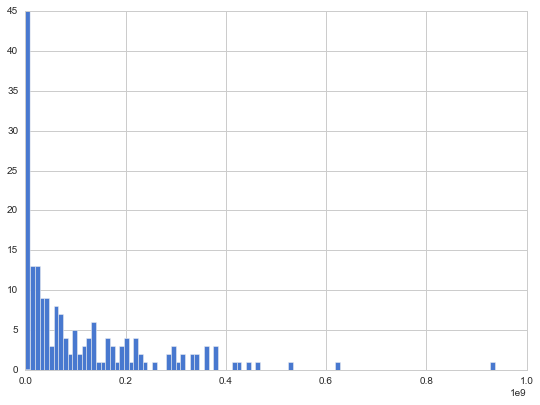

In [346]:
df['Gross'].hist(bins=100, figsize=(8,6))

## Count Vectorization

### Prepare columns for count vectorization

In [ ]:
# Columns reformatted for count vectorizer 

# Actor, Director, Plot, Title

In [347]:
# CountVectorizer w/parameters
cvec = CountVectorizer(stop_words='english', lowercase=True)

In [376]:
# Create column of first names only
df['Actor_First_Name'] = df['Actors'].apply(lambda x: x.split(',')[0])
df['Actor_First_Name'] = df['Actors'].apply(lambda x: x.split(' ')[0])
print df['Actor_First_Name'].head(3)

# Create column of lead actors only
df['Lead_Actor'] = df['Actors'].apply(lambda x: x.split(',')[0])
print df['Lead_Actor'].head(3)

# Create column of concatenated names to identify unique people
df['Actors'] = df['Actors'].apply(lambda x: x.replace(' ',''))
print df['Actors'].head(3)

0       Miles
1     Toshirô
2    Harrison
Name: Actor_First_Name, dtype: object
0      Miles Teller
1    Toshirô Mifune
2     Harrison Ford
Name: Lead_Actor, dtype: object
0    MilesTeller,J.K.Simmons,PaulReiser,MelissaBenoist
1    ToshirôMifune,TakashiShimura,KeikoTsushima,Yuk...
2      HarrisonFord,KarenAllen,PaulFreeman,RonaldLacey
Name: Actors, dtype: object


In [555]:
# Create column of lead actors only
df['Lead_Actor'] = df['Lead_Actor'].apply(lambda x: x[0])
print df['Lead_Actor'].head(3)

0    M
1    T
2    H
Name: Lead_Actor, dtype: object


In [389]:
actors = cvec.fit_transform(df['Actors']).todense()
actor_col = cvec.get_feature_names()
actors = pd.DataFrame(actors, columns=actor_col)
actors.head(3)

,aamirkhan,aaroneckhart,abdelahmedghili,adambaldwin,adamdriver,adolphemenjou,adrienbrody,agnesmoorehead,ahneyher,akemiyamaguchi,...,wrentz,xolanimali,yacefsaadi,yoshikoshinohara,yukikoshimazaki,yvesmontand,yôkotsukasa,zachgrenier,zoesaldana,álvaroguerrero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [542]:
actor_count = pd.DataFrame(actors.sum())
actor_count.columns = ['Count']
actor_count.sort_values(['Count'], ascending=False, inplace=True)
actor_count.head()

,Count
harrisonford,7
leonardodicaprio,7
robertdeniro,7
clinteastwood,6
tomhanks,6


In [552]:
lead_actors = cvec.fit_transform(df['Lead_Actor']).todense()
lead_actors_col = cvec.get_feature_names()
lead_actors = pd.DataFrame(lead_actors, columns=lead_actors_col)
lead_actors.head(2)

,aamir,abbott,abel,abraham,adolphson,adrien,affleck,al,alan,alba,...,wallach,weaver,wheaton,wil,william,willis,woody,xolani,yen,yves
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [553]:
lead_actor_count = pd.DataFrame(lead_actors.sum())
lead_actor_count.columns = ['Count']
lead_actor_count.sort_values(['Count'], ascending=False, inplace=True)
lead_actor_count.head()

,Count
tom,8
dicaprio,6
leonardo,6
robert,6
eastwood,5


In [550]:
actor_first_name = cvec.fit_transform(df['Actor_First_Name']).todense()
actor_first_name_col = cvec.get_feature_names()
actor_first_name = pd.DataFrame(actor_first_name, columns=actor_first_name_col)

actor_first_name_count = pd.DataFrame(actor_first_name.sum())
actor_first_name_count.columns = ['Count']
actor_first_name_count.sort_values(['Count'], ascending=False, inplace=True)
actor_first_name_count.head()

,Count
tom,8
robert,6
leonardo,6
clint,5
jean,4


In [ ]:
= df["Actors"].apply(lambda x: x.replace(" ",""))
cvec.fit(df["Actor Names"])
actors  = pd.DataFrame(cvec.transform(df["Actor Names"]).todense(),
             columns=cvec.get_feature_names())

# list of top 10 actors
top_actors =actors.sum(axis=0).sort_values(ascending=False)[:10]
cvec.fit(top_actors.index)
actors_count  = pd.DataFrame(cvec.transform(df["Actor Names"]).todense(),
             columns=cvec.get_feature_names())

# count of number of top 10 actors in each film
df["Actor Count"] = actors_count.sum(axis=1)

## EDA

### Histograms

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)
ax4 = fig.add_subplot(4, 1, 4)

ax1.hist(df['Year'], bins=50, color='royalblue')
ax1.set_xlabel('Year')
ax1.set_ylim(top=15)

ax2.hist(df['Runtime'], bins=50, color='coral')

ax3.hist(df['imdbRating'], bins=20, color='lightseagreen')

ax4.hist(df['Gross'], bins=20, color='tomato')
ax4.set_ylim(top=50000000000)

### Separate Histograms

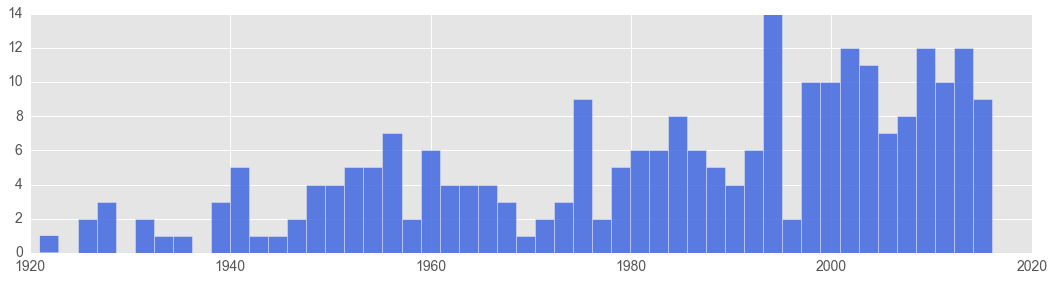

In [572]:
bins_dict = {'Year': 50, 'Runtime': 50, 'imdbRating': 50}
facecolor_dict = {'Year': 'royalblue', 'Runtime': 'coral', 'imdbRating': 'lightseagreen'}
axis_titles = {'Year': 'Distribution of Years in IMDB Top 250 Films',
              'Runtime': 'Distribution of Runtime in IMDB Top 250 Films',
              'imdbRating': 'Distribution of Years in IMDB Top 250 Films'}
#data, column=None, by=None, grid=True, xlabelsize=None, 
#xrot=None, ylabelsize=None, yrot=None, ax=None, sharex=False, 
#sharey=False, figsize=None, layout=None, bins=10, **kwds)¶
xlabel = 14
ylabel = 14
year_bins = 50
df['Year'].hist(figsize=(16,4),xlabelsize=xlabel, ylabelsize=ylabel, bins=bins_dict['Year'],
               facecolor=facecolor_dict['Year'], alpha = .85)

In [534]:
bins_dict = {'Year': 50, 'Runtime': 50, 'imdbRating': 50}
facecolor_dict = {'Year': 'royalblue', 'Runtime': 'coral', 'imdbRating': 'lightseagreen'}
axis_titles = {'Year': 'Distribution of Years in IMDB Top 250 Films',
              'Runtime': 'Distribution of Runtime in IMDB Top 250 Films',
              'imdbRating': 'Distribution of Years in IMDB Top 250 Films'}


def hist_plot(x):
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(111)
    n, bins, patches = ax.hist(x,  bins=bins_dict[x], facecolor=facecolor_dict[x], alpha=0.85)
    ax.set_title(axis_titles[x], fontsize=20, y=1.02)
    #ax.set_xticklabels(labels, fontsize=16)
    #ax.set_xticks(labels)
    #ax.set_ylim(0, 16)
    #y_labels = [i for i in range(18) if i%2 == 0]
    #ax.set_yticklabels(y_labels, fontsize=16)

TypeError: 'Series' objects are mutable, thus they cannot be hashed

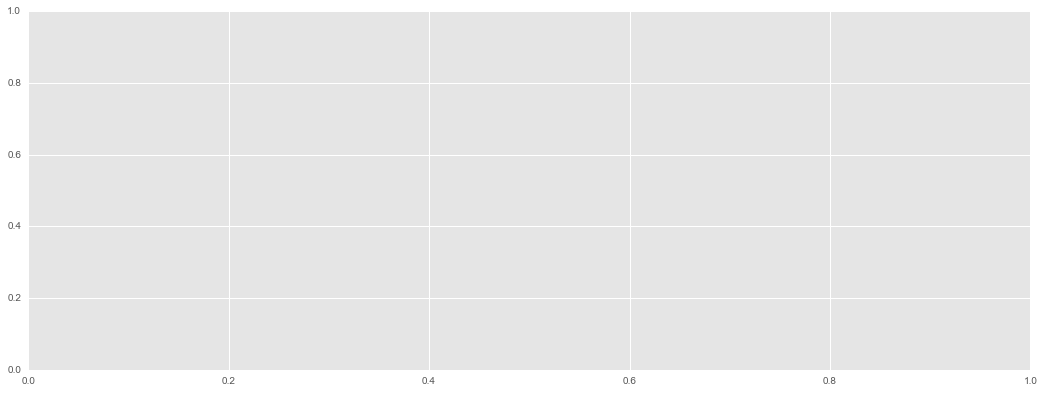

In [556]:
qb = df['Year']
hist_plot(qb)

In [ ]:
# Years histogram labels
def decades():
    i = 1910
    labels = []
    while i < 2020:
        labels.append(i + 10)
        i += 10
    return labels

years_xlabels = decades()
years_ylabels = [i for i in range(18) if i%2 == 0]



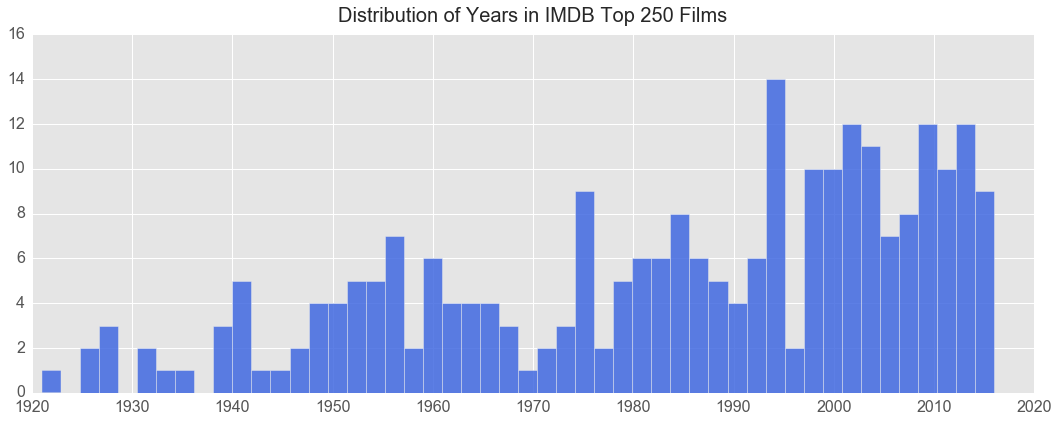

In [525]:
# Years
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(df['Year'],  bins=50, facecolor='royalblue', alpha=0.85)

def decades():
    i = 1910
    labels = []
    while i < 2020:
        labels.append(i + 10)
        i += 10
    return labels
labels = decades()

ax.set_title('Distribution of Years in IMDB Top 250 Films', fontsize=20, y=1.02)
ax.set_xticklabels(labels, fontsize=16)
ax.set_xticks(labels)
ax.set_ylim(0, 16)
y_labels = [i for i in range(18) if i%2 == 0]
ax.set_yticklabels(y_labels, fontsize=16)

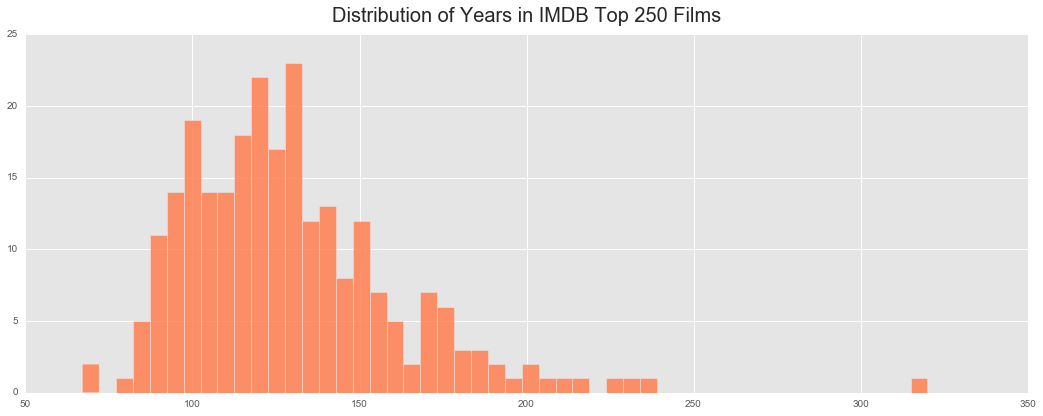

In [518]:
# Runtime
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(df['Runtime'],  bins=50, facecolor='coral', alpha=0.85)

ax.set_title('Distribution of Years in IMDB Top 250 Films', fontsize=20, y=1.02)